### Installs

In [ ]:
!pip install transformers pandas torch googletrans==4.0.0-rc1
!pip install transformers pandas torch googletrans==4.0.0-rc1 pinecone-client

### Imports

In [64]:
import torch
import pandas as pd
import os
from pinecone import Pinecone, ServerlessSpec
from tqdm.auto import tqdm
from transformers import pipeline, TapasTokenizer, TapasForQuestionAnswering
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from googletrans import Translator
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
url = "https://corgis-edu.github.io/corgis/datasets/csv/weather/weather.csv"
df = pd.read_csv(url)
df.head()

,Data.Precipitation,Date.Full,Date.Month,Date.Week of,Date.Year,Station.City,Station.Code,Station.Location,Station.State,Data.Temperature.Avg Temp,Data.Temperature.Max Temp,Data.Temperature.Min Temp,Data.Wind.Direction,Data.Wind.Speed
0,0.00,2016-01-03,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33
1,0.00,2016-01-03,1,3,2016,Huntsville,HSV,"Huntsville, AL",Alabama,39,47,31,32,3.86
2,0.16,2016-01-03,1,3,2016,Mobile,MOB,"Mobile, AL",Alabama,46,51,41,35,9.73
3,0.00,2016-01-03,1,3,2016,Montgomery,MGM,"Montgomery, AL",Alabama,45,52,38,32,6.86
4,0.01,2016-01-03,1,3,2016,Anchorage,ANC,"Anchorage, AK",Alaska,34,38,29,19,7.80


### Задание 1. Отобразить список городов, в которых температура поднималась выше значения средней температуры за все время наблюдений. Сортировка городов по алфавиту

In [58]:
avg_per_city = df[["Station.City", "Data.Temperature.Avg Temp"]].groupby(by="Station.City").mean()
average_temperature = avg_per_city["Data.Temperature.Avg Temp"].mean()

cities_above_average = avg_per_city[avg_per_city["Data.Temperature.Avg Temp"] > average_temperature].index.tolist()
cities_above_average.sort()
print(f"{len(cities_above_average)} of {len(avg_per_city)} cities are above average temperature")
print(f"list of these cities {cities_above_average}")

150 of 307 cities are above average temperature
list of these cities ['Abilene', 'Albuquerque', 'Alma', 'Amarillo', 'Anderson', 'Asheville', 'Athens', 'Atlanta', 'Augusta', 'Austin/Bergstrom', 'Austin/City', 'Bakersfield', 'Baltimore', 'Baton Rouge', 'Beaumont/Port Arthur', 'Birmingham', 'Bishop', 'Blacksburg', 'Bristol/Jhnsn Cty/Kngsprt', 'Brownsville', 'Cape Girardeau', 'Cape Hatteras', 'Charleston', 'Charlotte', 'Chattanooga', 'Childress', 'China Lake', 'Clarksville', 'College Station', 'Columbia', 'Corpus Christi', 'Crossville', 'Dalhart', 'Dallas', 'Dallas-Fort Worth', 'Daytona Beach', 'Del Rio', 'Dodge City', 'Douglas Bisbee', 'El Paso', 'Evansville', 'Fort Lauderdale', 'Fort Smith', 'Fort Worth', 'Fresno', 'Gage', 'Gainesville', 'Galveston', 'Greensboro', 'Greenville', 'Greenwood', 'Greer', 'Gulfport', 'Gustavus', 'Harrison', 'Hattiesburg', 'Hayward', 'Hickory', 'Hilo', 'Honolulu', 'Houston', 'Huntington', 'Huntsville', 'Jackson', 'Jacksonville', 'Kahului', 'Kansas City', 'Kauna

### Задание 2. Отобразить диаграмму средней температуры по каждому месяцу за первый календарный год наблюдений

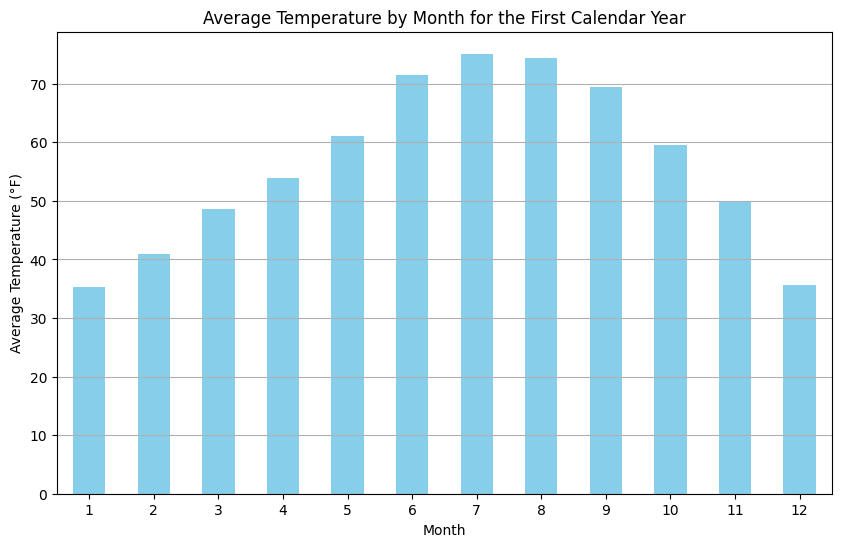

In [65]:
first_year = df['Date.Year'].min()
first_year_data = df[df['Date.Year'] == first_year]

monthly_avg_temp = first_year_data.groupby('Date.Month')['Data.Temperature.Avg Temp'].mean()

plt.figure(figsize=(10, 6))
monthly_avg_temp.plot(kind='bar', color='skyblue')
plt.title('Average Temperature by Month for the First Calendar Year')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°F)')
plt.xticks(rotation=0)
plt.grid(axis='y')

### Задание 3. Вывести список 3х лучших городов для жизни, по мнению одной из популярных LLM, с кратким описанием (на русском языке) причин такого выбора возле каждого из городов.


In [5]:
# # Загрузка датасета
# url = "https://corgis-edu.github.io/corgis/datasets/csv/weather/weather.csv"
# df = pd.read_csv(url)

# Преобразование необходимых столбцов в числовые значения
df['Data.Temperature.Max Temp'] = pd.to_numeric(df['Data.Temperature.Max Temp'], errors='coerce')
df['Data.Temperature.Min Temp'] = pd.to_numeric(df['Data.Temperature.Min Temp'], errors='coerce')
df['Data.Temperature.Avg Temp'] = pd.to_numeric(df['Data.Temperature.Avg Temp'], errors='coerce')
df['Data.Wind.Speed'] = pd.to_numeric(df['Data.Wind.Speed'], errors='coerce')

# Группировка данных по городам и расчет средних значений
grouped = df.groupby('Station.City')[['Data.Temperature.Max Temp', 'Data.Temperature.Min Temp', 'Data.Temperature.Avg Temp', 'Data.Wind.Speed']].mean()

# Классификация температур и скорости ветра
def classify_temp(temp):
    if temp < 50:
        return 'cold'
    elif 50 <= temp <= 75:
        return 'comfortable'
    else:
        return 'hot'

def classify_wind(speed):
    if speed < 5:
        return 'weak'
    elif 5 <= speed <= 15:
        return 'moderate'
    elif 15 <= speed <= 30:
        return 'strong'
    else:
        return 'hurricane'

# Подсчет количества месяцев для каждой категории
temp_counts = df.groupby('Station.City')['Data.Temperature.Avg Temp'].apply(lambda x: x.apply(classify_temp).value_counts()).unstack().fillna(0)
wind_counts = df.groupby('Station.City')['Data.Wind.Speed'].apply(lambda x: x.apply(classify_wind).value_counts()).unstack().fillna(0)

# Создание расширенного описания
def generate_description(row):
    city = row.name
    max_temp = round(row['Data.Temperature.Max Temp'], 1)
    min_temp = round(row['Data.Temperature.Min Temp'], 1)
    avg_temp = round(row['Data.Temperature.Avg Temp'], 1)
    avg_wind_speed = round(row['Data.Wind.Speed'], 1)
    cold_months = temp_counts.loc[city, 'cold'] if 'cold' in temp_counts.columns else 0
    comfortable_months = temp_counts.loc[city, 'comfortable'] if 'comfortable' in temp_counts.columns else 0
    hot_months = temp_counts.loc[city, 'hot'] if 'hot' in temp_counts.columns else 0
    weak_wind_months = wind_counts.loc[city, 'weak'] if 'weak' in wind_counts.columns else 0
    moderate_wind_months = wind_counts.loc[city, 'moderate'] if 'moderate' in wind_counts.columns else 0
    strong_wind_months = wind_counts.loc[city, 'strong'] if 'strong' in wind_counts.columns else 0
    hurricane_wind_months = wind_counts.loc[city, 'hurricane'] if 'hurricane' in wind_counts.columns else 0

    description = (f"In {city}, the maximum recorded temperature is {max_temp}°F, the minimum recorded temperature is {min_temp}°F, "
                   f"the average temperature is {avg_temp}°F. The average wind speed is {avg_wind_speed} mph. "
                   f"There are {cold_months} cold months, {comfortable_months} comfortable months, and {hot_months} hot months. "
                   f"There are {weak_wind_months} months with weak wind, {moderate_wind_months} months with moderate wind, "
                   f"{strong_wind_months} months with strong wind, and {hurricane_wind_months} months with hurricane wind.")
    return description

grouped['Description'] = grouped.apply(generate_description, axis=1)

# Нормализация данных и расчет общего балла
grouped['Comfortable_Temp_Score'] = temp_counts['comfortable'] / temp_counts['comfortable'].max()
grouped['Cold_Temp_Penalty'] = temp_counts['cold'] / temp_counts['cold'].max()
grouped['Hot_Temp'] = temp_counts['hot'] / temp_counts['hot'].max()

grouped['Weak_Wind_Score'] = wind_counts['weak'] / wind_counts['weak'].max()
grouped['Moderate_Wind_Score'] = wind_counts['moderate'] / wind_counts['moderate'].max()
grouped['Strong_Wind_Penalty'] = wind_counts['strong'] / wind_counts['strong'].max()
grouped['Hurricane_Wind_Penalty'] = wind_counts['hurricane'] / wind_counts['hurricane'].max()

grouped['Temp_Score'] = (grouped['Data.Temperature.Avg Temp'] - grouped['Data.Temperature.Avg Temp'].min()) / (grouped['Data.Temperature.Avg Temp'].max() - grouped['Data.Temperature.Avg Temp'].min())
grouped['Max_Temp_Score'] = (grouped['Data.Temperature.Max Temp'] - grouped['Data.Temperature.Max Temp'].min()) / (grouped['Data.Temperature.Max Temp'].max() - grouped['Data.Temperature.Max Temp'].min())
grouped['Wind_Score'] = (grouped['Data.Wind.Speed'].max() - grouped['Data.Wind.Speed']) / (grouped['Data.Wind.Speed'].max() - grouped['Data.Wind.Speed'].min())


# Рассчет общего балла с учетом всех факторов
grouped['Total_Score'] = (
    grouped['Comfortable_Temp_Score'] * 0.4 +
    grouped['Weak_Wind_Score'] * 0.2 +
    grouped['Moderate_Wind_Score'] * 0.2 -
    grouped['Cold_Temp_Penalty'] * 0.05 +
    grouped['Hot_Temp'] * 0.1 -
    grouped['Strong_Wind_Penalty'] * 0.05 -
    grouped['Hurricane_Wind_Penalty'] * 0.05
)

# Рассчет балла с учетом температуры и скорости ветра
grouped['Weather_Score'] = grouped['Comfortable_Temp_Score'] * 0.4 + grouped['Max_Temp_Score'] * 0.4 + grouped['Wind_Score'] * 0.2

# Получение списка лучших городов
best_cities = grouped.sort_values(by='Total_Score', ascending=False)

# Формирование описания для лучших городов
best_cities['Full_Description'] = best_cities.apply(
    lambda row: f"City: {row.name}, Description: {row['Description']}", axis=1
)

# Формирование описания для лучших городов
best_cities['Full_Description'] = best_cities.apply(
    lambda row: f"City: {row.name}, Description: {row['Description']}", axis=1
)

best_cities[['Full_Description', 'Total_Score']]

# Создание test_df
test_df = best_cities[[]].copy()

test_df['Cold Months'] = temp_counts.loc[test_df.index, 'cold']
test_df['Comfortable Months'] = temp_counts.loc[test_df.index, 'comfortable']
test_df['Hot Months'] = temp_counts.loc[test_df.index, 'hot']
test_df['Weak Wind Months'] = wind_counts.loc[test_df.index, 'weak']
test_df['Moderate Wind Months'] = wind_counts.loc[test_df.index, 'moderate']
test_df['Strong Wind Months'] = wind_counts.loc[test_df.index, 'strong']
test_df['Hurricane Wind Months'] = wind_counts.loc[test_df.index, 'hurricane']

# Преобразование данных в строки и создание итогового описания
def create_description(row):
    description = (f"City: {row.name}, "
                   f"Cold Months: {row['Cold Months']}, "
                   f"Comfortable Months: {row['Comfortable Months']}, Hot Months: {row['Hot Months']}, "
                   f"Weak Wind Months: {row['Weak Wind Months']}, Moderate Wind Months: {row['Moderate Wind Months']}, "
                   f"Strong Wind Months: {row['Strong Wind Months']}, Hurricane Wind Months: {row['Hurricane Wind Months']} "
                   )
    return description

test_df['Final_Description'] = test_df.apply(create_description, axis=1)


In [6]:
test_df = test_df.astype(str)
test_df['Final_Description'][0]

'City: Eureka, Cold Months: 37.0, Comfortable Months: 68.0, Hot Months: 1.0, Weak Wind Months: 92.0, Moderate Wind Months: 14.0, Strong Wind Months: 0.0, Hurricane Wind Months: 0.0 '

In [7]:
def split_dataframe(df, chunk_size):
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    return chunks

# Разделение `test_df` на таблицы по 5 строк
chunk_size = 5
tables = split_dataframe(test_df, chunk_size)

In [8]:
len(tables)

62

In [9]:
def _preprocess_tables(tables: list):
    processed = []
    # loop through all tables
    for table in tables:
        # convert the table to csv and
        processed_table = "\n".join([table.to_csv(index=False)])
        # add the processed table to processed list
        processed.append(processed_table)
    return processed

In [10]:
# format all the dataframes in the tables list
processed_tables = _preprocess_tables(tables)
# display the formatted table
processed_tables[2]

'Cold Months,Comfortable Months,Hot Months,Weak Wind Months,Moderate Wind Months,Strong Wind Months,Hurricane Wind Months,Final_Description\n51.0,50.0,5.0,9.0,97.0,0.0,0.0,"City: Rochester, Cold Months: 51.0, Comfortable Months: 50.0, Hot Months: 5.0, Weak Wind Months: 9.0, Moderate Wind Months: 97.0, Strong Wind Months: 0.0, Hurricane Wind Months: 0.0 "\n0.0,53.0,0.0,52.0,1.0,0.0,0.0,"City: Santa Barbara, Cold Months: 0.0, Comfortable Months: 53.0, Hot Months: 0.0, Weak Wind Months: 52.0, Moderate Wind Months: 1.0, Strong Wind Months: 0.0, Hurricane Wind Months: 0.0 "\n0.0,53.0,0.0,38.0,15.0,0.0,0.0,"City: San Diego, Cold Months: 0.0, Comfortable Months: 53.0, Hot Months: 0.0, Weak Wind Months: 38.0, Moderate Wind Months: 15.0, Strong Wind Months: 0.0, Hurricane Wind Months: 0.0 "\n0.0,53.0,0.0,23.0,30.0,0.0,0.0,"City: Los Angeles, Cold Months: 0.0, Comfortable Months: 53.0, Hot Months: 0.0, Weak Wind Months: 23.0, Moderate Wind Months: 30.0, Strong Wind Months: 0.0, Hurricane Wind Mo

In [34]:
pc = Pinecone(api_key="619377d2-4f57-473a-be36-5ec29408c57b")

# you can choose any name for the index
index_name = "table-qa1"

if index_name not in pc.list_indexes().names():
    # create the index if it does not exist
    pc.create_index(
        index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
# Подключение к индексу
index = pc.Index(index_name)

# Векторизация описаний (используем трансформеры для создания векторов)
embedding_model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embedding_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def embed_text(text):
    inputs = embedding_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = embedding_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

batch_size = 5  # Поскольку мы обрабатываем таблицы по 5 строк

for i in tqdm(range(0, len(processed_tables), batch_size)):
    i_end = min(i + batch_size, len(processed_tables))
    batch = processed_tables[i:i_end]
    # Генерация эмбеддингов для батча
    embeddings = [embed_text(text).tolist() for text in batch]
    # Создание уникальных ID для каждой таблицы
    ids = [f"{idx}" for idx in range(i, i_end)]
    # Подготовка данных для загрузки в Pinecone
    to_upsert = list(zip(ids, embeddings))
    # Загрузка эмбеддингов в индекс
    _ = index.upsert(vectors=to_upsert)

# Проверка наличия всех векторов в индексе
index.describe_index_stats()

'''

Дальнейшая реализация необходима для целой таблицы. Реализация выше состоит из
групп таблиц.

'''

# # Подготовка данных для векторизации
# weather_data_lines = test_df.tolist()

# for i in tqdm(range(0, len(weather_data_lines), batch_size)):
#     i_end = min(i + batch_size, len(weather_data_lines))
#     batch = weather_data_lines[i:i_end]
#     emb = [embed_text(text) for text in batch]
#     ids = [f"{idx}" for idx in range(i, i_end)]
#     to_upsert = list(zip(ids, emb))
#     _ = index.upsert(vectors=to_upsert)

# # Проверка наличия всех векторов в индексе
# index.describe_index_stats()


  0%|          | 0/13 [00:00<?, ?it/s]

'\n\nДальнейшая реализация необходима для целой таблицы. Реализация выше состоит из\nгрупп таблиц.\n\n'

In [35]:
model_name = "google/tapas-base-finetuned-wtq"

tokenizer = TapasTokenizer.from_pretrained(model_name)
model = TapasForQuestionAnswering.from_pretrained(model_name, local_files_only=False)

pipe = pipeline("table-question-answering",  model=model, tokenizer=tokenizer, device=device)

In [36]:
# Функция для выполнения запроса в Pinecone
def query_pinecone(query):
    # Векторизация запроса
    query_vector = embed_text(query)
    # Запрос к индексу Pinecone для нахождения таблицы, содержащей ответ на запрос
    result = index.query(vector=query_vector.tolist(), top_k=1)
    # Возвращаем соответствующую таблицу из списка tables
    return tables[int(result["matches"][0]["id"])]

# Функция для получения ответа из таблицы
def get_answer_from_table(table, query):
    # Преобразование таблицы в формат, который понимает пайплайн
    table_csv = table.to_csv(index=False)
    # Получение ответов на запрос из таблицы
    answers = pipe(table=table_csv, query=query)
    return answers

In [40]:
query = "Name 3 best cities for living"
table = query_pinecone(query)
table.head(3)

,Cold Months,Comfortable Months,Hot Months,Weak Wind Months,Moderate Wind Months,Strong Wind Months,Hurricane Wind Months,Final_Description
Station.City,,,,,,,,
Birmingham,9.0,26.0,18.0,30.0,23.0,0.0,0.0,"City: Birmingham, Cold Months: 9.0, Comfortabl..."
Brownsville,1.0,23.0,29.0,3.0,48.0,2.0,0.0,"City: Brownsville, Cold Months: 1.0, Comfortab..."
North Little Rock,12.0,27.0,14.0,53.0,0.0,0.0,0.0,"City: North Little Rock, Cold Months: 12.0, Co..."


In [41]:
# Инициализация модели
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1.5").to(device)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1.5")

# Создание пайплайна
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Используем GPU если доступен
)

# Инициализация переводчика
translator = Translator()

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [61]:
generation_args = {
    "max_new_tokens": 150,
    "num_return_sequences": 1,
    "do_sample": True,
    "top_p": 0.96,
    "top_k": 20,
}

# Функция для получения ближайших соседей
def get_nearest_neighbors(vector, top_k=3):
    response = index.query(vector=vector.tolist(), top_k=top_k)
    return response['matches']

# Создание результирующего DataFrame
results = []

# Проход по всем таблицам из списка tables
for i, table in enumerate(tables):
    descriptions = " ".join(table['Final_Description'].tolist())
    query = f"Based on the comfortable months and Moderate Wind Months: {descriptions}, what are the three best cities for living and why?"

    # Генерация текста
    response = pipe(query, **generation_args)
    generated_text = response[0]['generated_text']

    # Векторизация запроса
    query_vector = embed_text(query)

    # Получение ближайших соседей
    nearest_neighbors = get_nearest_neighbors(query_vector, top_k=3)

    # Извлечение названий городов и добавление в результаты
    for neighbor in nearest_neighbors:
        score = neighbor['score']
        results.append({
            "Generated Text": generated_text,
            "Score": score
        })

# Преобразование результатов в DataFrame и сортировка по значению вектора близости
results_df = pd.DataFrame(results).sort_values(by='Score', ascending=False).head(3)

In [62]:
results_df['Translated Text'] = results_df['Generated Text'].apply(lambda x: translator.translate(x, src='en', dest='ru').text)

In [63]:
for idx, row in results_df.iterrows():
    print(f"{row['Translated Text']}")
    print()

На основании удобных месяцев и умеренных ветровых месяцев: Город: Шривпорт, холодные месяцы: 5,0, удобные месяцы: 29,0, жаркие месяцы: 19,0, слабый ветер Месяцы: 21,0, умеренный ветер месяцы: 32,0, сильный ветер.: 0,0 Город: Кейп -Хаттерас, холодные месяцы: 6,0, удобные месяцы: 30,0, горячие месяцы: 17,0, слабый ветер Месяцы: 10,0, умеренный ветер Месяцы: 43,0, сильные ветры Месяцы: 0,0, ураган ветер Месяцы: 0,0 Город: Хэттисберг, холодМесяцы: 6,0, удобные месяцы: 29,0, жаркие месяцы: 18,0, слабый ветер месяцы: 42,0, умеренный ветер месяцы: 11,0, сильный ветер Месяцы: 0,0, ураган ветер Месяцы: 0,0 Город: Станция колледжа, холодные месяцы: 4,0, удобные месяцы:28,0, горячие месяцы: 21,0, слабый ветер Месяцы: 9,0, умеренный ветер Месяцы: 44,0, сильный ветер., Слабый ветер месяцы: 12,0, умеренный ветер месяцы: 41,0, сильный ветер месяцы: 0,0, ураган ветер месяцы: 0,0, каковы три лучших города для жизни и почему?

4. Как узнать лучший сезон для посещения города?
О. Вы можете узнать лучший с

In [ ]:
# Создание запроса и обработка каждого города
results = []

for idx, row in best_cities.iterrows():
    city = row.name
    description = row['Full_Description']

    query = f"Based on the following description: {description}, is this city suitable for living? Why?"

    # Генерация текста
    response = pipe(query, **generation_args)
    generated_text = response[0]['generated_text']

    # Перевод сгенерированного текста на русский язык
    translated_text = translator.translate(generated_text, src='en', dest='ru').text

    results.append({
        "City": city,
        "Generated Text": generated_text,
        "Translated Text": translated_text
    })

# Преобразование результатов в DataFrame и вывод
results_df = pd.DataFrame(results).head(3)
results_df[['City', 'Translated Text']]

,City,Translated Text
0,San Juan,На основании следующего описания: Город: Сан -...
1,Phoenix,На основании следующего описания: Город: Феник...
2,Miami,Основываясь на следующем описании: Город: Майа...


In [ ]:
for idx, row in results_df.iterrows():
    print(f"Город: {row['City']}")
    print(f"Описание: {row['Translated Text']}")
    print()

Город: San Juan
Описание: На основании следующего описания: Город: Сан -Хуан, Описание: В Сан -Хуане максимальная зарегистрированная температура составляет 86,6 ° F, минимальная зарегистрированная температура составляет 75,6 ° F, средняя температура составляет 81,4 ° F.Средняя скорость ветра составляет 6,7 миль в час.Есть 0,0 холодных месяцев, 0,0 удобных месяцев и 53,0 горячих месяцев.Есть 16,0 месяцев со слабым ветром, 37,0 месяцев с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром. Подходит ли этот город для жизни?Почему?

Ответ: Да, город подходит для жизни.Минимальная зарегистрированная температура составляет 75,6 ° F, что значительно ниже точки замораживания и является удобной температурой. Средняя температура составляет 81,4 ° F, что представляет собой умеренную температуру, которая обеспечивает удобную среду жила.Средняя скорость ветра составляет 6,7 миль в час, что является умеренным ветром, который помогает сохранить стабильную температуру.Количес

## Результаты с использованием модели Phi-2

In [15]:
descriptions = " ".join(best_cities['Full_Description'].tolist())
# query = f"Based on the following data: {descriptions}, name three cities from data for best living with moderate temperature, low wind speed, and no hurricanes? Explain why? "
# query = f"Answer which three best city for living with  moderate temperature, low wind speed in presented data: {descriptions}"
# query = f"There are some data: {descriptions}. Name three cities for the best live based on temperature and wind speed."
# query = f"Based on the following description: {descriptions}, nsme three city suitable for living? Why?"
# query = f"Based on the following data: {descriptions}, what are the three best cities for living with moderate temperature, low wind speed, and no hurricanes?"


In [19]:
query1 = f"Based on the following data: {descriptions}, what are the three best cities for living and why?"

In [25]:
# Параметры генерации
generation_args = {
    "max_new_tokens": 170,
    "num_return_sequences": 1,
    "do_sample": True,
    "top_p": 0.95,
    "top_k": 20
}


# Генерация текста
response2 = pipe(query1, **generation_args)
generated_text2 = response2[0]['generated_text']

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [23]:
def translate_and_extract_answer(generated_text):
    # Перевод сгенерированного текста на русский язык
    translated_text = translator.translate(generated_text, src='en', dest='ru').text

    # Извлечение нужной части перевода
    # if "Ответ:" in translated_text:
    #     answer_start = translated_text.index("Ответ:") + len("Ответ:")
    #     answer_end = translated_text.find("\n", answer_start)
    #     answer = translated_text[answer_start:answer_end].strip() if answer_end != -1 else translated_text[answer_start:].strip()
    # else:
    #     answer = translated_text.strip()

    return translated_text

# Применение функции к сгенерированному тексту
answer = translate_and_extract_answer(generated_text)

print(f"Ответ: {answer}")

Ответ: На основании следующих данных: город: Eureka, Описание: В Eureka максимальная зарегистрированная температура составляет 61,7 ° F, минимальная зарегистрированная температура составляет 38,5 ° F, средняя температура составляет 50,8 ° F.Средняя скорость ветра составляет 2,1 миль в час.Есть 37,0 холодных месяцев, 68,0 удобных месяцев и 1,0 горячих месяцев.Существует 92,0 месяца со слабым ветром, 14,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Согласие, Описание: В согласии максимальная зарегистрированная температура составляет 67,1 ° F, минимальная зарегистрированная температура составляет 43,7 ° F, средняя температура составляет 55,7 ° F.Средняя скорость ветра составляет 5,0 миль в час.Есть 35,0 холодных месяцев, 67,0 удобных месяцев и 4,0 горячих месяцев.Существует 59,0 месяца со слабым ветром, 47,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Чарльстон, Описание: В Чарльстоне макси

In [24]:
answer1 = translate_and_extract_answer(generated_text1)

print(f"Ответ: {answer1}")

Ответ: На основании следующих данных: город: Eureka, Описание: В Eureka максимальная зарегистрированная температура составляет 61,7 ° F, минимальная зарегистрированная температура составляет 38,5 ° F, средняя температура составляет 50,8 ° F.Средняя скорость ветра составляет 2,1 миль в час.Есть 37,0 холодных месяцев, 68,0 удобных месяцев и 1,0 горячих месяцев.Существует 92,0 месяца со слабым ветром, 14,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Согласие, Описание: В согласии максимальная зарегистрированная температура составляет 67,1 ° F, минимальная зарегистрированная температура составляет 43,7 ° F, средняя температура составляет 55,7 ° F.Средняя скорость ветра составляет 5,0 миль в час.Есть 35,0 холодных месяцев, 67,0 удобных месяцев и 4,0 горячих месяцев.Существует 59,0 месяца со слабым ветром, 47,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Чарльстон, Описание: В Чарльстоне макси

In [26]:
answer2 = translate_and_extract_answer(generated_text2)

print(f"Ответ: {answer2}")

Ответ: На основании следующих данных: город: Eureka, Описание: В Eureka максимальная зарегистрированная температура составляет 61,7 ° F, минимальная зарегистрированная температура составляет 38,5 ° F, средняя температура составляет 50,8 ° F.Средняя скорость ветра составляет 2,1 миль в час.Есть 37,0 холодных месяцев, 68,0 удобных месяцев и 1,0 горячих месяцев.Существует 92,0 месяца со слабым ветром, 14,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Согласие, Описание: В согласии максимальная зарегистрированная температура составляет 67,1 ° F, минимальная зарегистрированная температура составляет 43,7 ° F, средняя температура составляет 55,7 ° F.Средняя скорость ветра составляет 5,0 миль в час.Есть 35,0 холодных месяцев, 67,0 удобных месяцев и 4,0 горячих месяцев.Существует 59,0 месяца со слабым ветром, 47,0 месяца с умеренным ветром, 0,0 месяца с сильным ветром и 0,0 месяца с ураганным ветром.Город: Чарльстон, Описание: В Чарльстоне макси